# Advanced clustering on real-world data

## K-means and Hierarchical clustering


### Package import

**Tip**: look at the documentation of the packages and methods imported, they can help you answer some questions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, StandardScaler


Load the dataset, separate the labels from the variables. In some cases, you might also want to drop some variables (e.g. names, identifiers, anything that has one unique value per sample that will not help you form groups).

In [3]:
df = pd.read_csv("hr_data.csv", header=0)
df.info()
classes = df["Status"]
df = df.drop("Status", axis=1)
df = df.drop("SLNO", axis=1)
df = df.drop("Candidate Ref", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8995 entries, 0 to 8994
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SLNO                         8995 non-null   int64  
 1   Candidate Ref                8995 non-null   int64  
 2   DOJ Extended                 8995 non-null   object 
 3   Duration to accept offer     8995 non-null   int64  
 4   Notice period                8995 non-null   int64  
 5   Offered band                 8995 non-null   object 
 6   Pecent hike expected in CTC  8995 non-null   float64
 7   Percent hike offered in CTC  8995 non-null   float64
 8   Percent difference CTC       8995 non-null   float64
 9   Joining Bonus                8995 non-null   object 
 10  Candidate relocate actual    8995 non-null   object 
 11  Gender                       8995 non-null   object 
 12  Candidate Source             8995 non-null   object 
 13  Rex in Yrs        

### Data preprocessing

Visualize the 10 first rows of both data and classes

In [4]:
classes.head(10)

0    Joined
1    Joined
2    Joined
3    Joined
4    Joined
5    Joined
6    Joined
7    Joined
8    Joined
9    Joined
Name: Status, dtype: object

In [5]:
df.head(10)


,DOJ Extended,Duration to accept offer,Notice period,Offered band,Pecent hike expected in CTC,Percent hike offered in CTC,Percent difference CTC,Joining Bonus,Candidate relocate actual,Gender,Candidate Source,Rex in Yrs,LOB,Location,Age
0,Yes,14,30,E2,-20.79,13.16,42.86,No,No,Female,Agency,7,ERS,Noida,34
1,No,18,30,E2,50.00,320.00,180.00,No,No,Male,Employee Referral,8,INFRA,Chennai,34
2,No,3,45,E2,42.84,42.84,0.00,No,No,Male,Agency,4,INFRA,Noida,27
3,No,26,30,E2,42.84,42.84,0.00,No,No,Male,Employee Referral,4,INFRA,Noida,34
4,Yes,1,120,E2,42.59,42.59,0.00,No,Yes,Male,Employee Referral,6,INFRA,Noida,34
5,Yes,17,30,E1,42.83,42.83,0.00,No,No,Male,Employee Referral,2,INFRA,Noida,34
6,Yes,37,30,E2,31.58,31.58,0.00,No,No,Male,Employee Referral,7,INFRA,Noida,32
7,Yes,16,0,E1,-20.00,-20.00,0.00,No,No,Female,Direct,8,Healthcare,Noida,34
8,No,1,30,E1,-22.22,-22.22,0.00,No,No,Female,Employee Referral,3,BFSI,Gurgaon,26
9,No,6,30,E1,240.00,220.00,-5.88,No,No,Male,Employee Referral,3,CSMP,Chennai,34


Are there any missing values (in data)? What type are the variables?

In [6]:
class_counts = df.value_counts()
class_counts.count()

8833

In [7]:
df.isnull().sum()

DOJ Extended                   0
Duration to accept offer       0
Notice period                  0
Offered band                   0
Pecent hike expected in CTC    0
Percent hike offered in CTC    0
Percent difference CTC         0
Joining Bonus                  0
Candidate relocate actual      0
Gender                         0
Candidate Source               0
Rex in Yrs                     0
LOB                            0
Location                       0
Age                            0
dtype: int64

There are no missing values in the data

Use the describe method and explain what you obtain.

In [9]:
df.describe()

,Duration to accept offer,Notice period,Pecent hike expected in CTC,Percent hike offered in CTC,Percent difference CTC,Rex in Yrs,Age
count,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000,8995.000000
mean,21.434464,39.291829,43.864804,40.657356,-1.573802,4.239022,29.913174
std,25.811616,22.220239,29.788975,36.064060,19.610729,2.547571,4.097912
min,0.000000,0.000000,-68.830000,-60.530000,-67.270000,0.000000,20.000000
25%,3.000000,30.000000,27.270000,22.090000,-8.330000,3.000000,27.000000
50%,10.000000,30.000000,40.000000,36.000000,0.000000,4.000000,29.000000
75%,33.000000,60.000000,53.850000,50.000000,0.000000,6.000000,34.000000
max,224.000000,120.000000,359.770000,471.430000,300.000000,24.000000,60.000000


If your dataset contains missing data, follow the process seen in the first practical to impute missing data. Make sure to impute numeric and nominal data with different strategies.

In [10]:
df.isnull().sum()

DOJ Extended                   0
Duration to accept offer       0
Notice period                  0
Offered band                   0
Pecent hike expected in CTC    0
Percent hike offered in CTC    0
Percent difference CTC         0
Joining Bonus                  0
Candidate relocate actual      0
Gender                         0
Candidate Source               0
Rex in Yrs                     0
LOB                            0
Location                       0
Age                            0
dtype: int64

In [ ]:
df_nom = df.select_dtypes(include=['object'])
df_num = df.select_dtypes(include=['int64', 'float64'])

In [12]:
df_nom.columns

Index(['DOJ Extended', 'Offered band', 'Joining Bonus',
       'Candidate relocate actual', 'Gender', 'Candidate Source', 'LOB',
       'Location'],
      dtype='object')

In [13]:
df_num.columns

Index(['Duration to accept offer', 'Notice period',
       'Pecent hike expected in CTC', 'Percent hike offered in CTC',
       'Percent difference CTC', 'Rex in Yrs', 'Age'],
      dtype='object')

Explain your choice of imputation strategy for each data type.

No need for imputation strategy as there is no missing data

Do you think the data should be scaled? If yes, do it and compare the obtained data to the original data (compare only the first 20 features if the dataset is large).

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import pandas as pd

new_df = df.copy()
# Convert binary categorical columns to numerical
binary_cols = ['DOJ Extended', 'Joining Bonus', 'Candidate relocate actual']
new_df[binary_cols] = new_df[binary_cols].replace({'Yes': 1, 'No': 0})


# Initialize the label encoder
le = LabelEncoder()

# Apply label encoding to these columns
new_df['Offered band'] = le.fit_transform(new_df['Offered band'])
new_df['Gender'] = le.fit_transform(new_df['Gender'])
new_df['Candidate Source'] = le.fit_transform(new_df['Candidate Source'])
new_df['LOB'] = le.fit_transform(new_df['LOB'])
new_df['Location'] = le.fit_transform(new_df['Location'])

scaler = StandardScaler()


# Mise à l'échelle des données
scaled_features = scaler.fit_transform(new_df)

# Création d'un DataFrame pour les données mises à l'échelle
scaled_df = pd.DataFrame(scaled_features, columns=new_df.columns)

C:\Users\aniso\AppData\Local\Temp\ipykernel_22936\1849118409.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  new_df[binary_cols] = new_df[binary_cols].replace({'Yes': 1, 'No': 0})


How many classes are there? Plot the distribution of the classes. Is the data balanced or imbalanced?

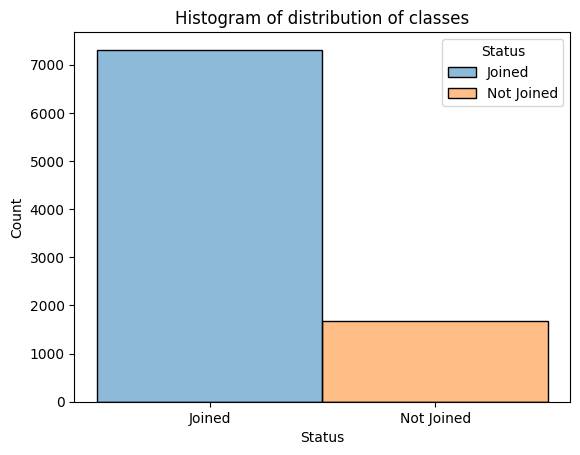

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

classes_df = classes.to_frame(name='Status')

hist = sns.histplot(data=classes_df, x="Status", hue="Status")

plt.title("Histogram of distribution of classes")

plt.show()

There are two classes: joined and not joined

In [18]:
is_imbalanced = classes.value_counts().max() / classes.value_counts().min() > 2
if is_imbalanced:
    print("The data is imbalanced.")
else:
    print("The data is balanced.")

The data is imbalanced.


Encode your classes into a numerical variable.

In [ ]:
for cat in classes_df:
  classes_df[cat] = pd.factorize(classes_df.loc[:,cat])[0]

classes_df.value_counts()

Check if your data and classes are numpy arrays. If that is not the case, transform your data and classes into numpy arrays.

In [21]:
print(isinstance(scaled_df,np.ndarray))
print(isinstance(classes_df,np.ndarray))


False
False


In [22]:
classes_df.to_numpy()
df.to_numpy()
scaled_df.to_numpy()

array([[ 1.06681918, -0.28804384, -0.41819285, ..., -0.07392111,
         1.3536762 ,  0.99735016],
       [-0.93736597, -0.13306623, -0.41819285, ...,  1.18460329,
        -0.64511739,  0.99735016],
       [-0.93736597, -0.71423225,  0.25690491, ...,  1.18460329,
         1.3536762 , -0.71093179],
       ...,
       [-0.93736597, -0.83046545, -1.76838837, ...,  1.18460329,
         1.3536762 ,  0.99735016],
       [-0.93736597, -0.83046545, -0.41819285, ...,  1.18460329,
         1.3536762 ,  0.99735016],
       [-0.93736597, -0.75297665, -1.76838837, ...,  1.18460329,
        -0.64511739,  0.99735016]])

### Clustering algorithm 1: K-means

Apply the K-means algorithm with 2 centers. Look at the default parameters the method takes. Make sure the algorithm doesn't run more than 500 iterations.

In [23]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, max_iter=500)
kmeans.fit(scaled_df)

KMeans(max_iter=500, n_clusters=2)

In [24]:
kmeans.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 500,
 'n_clusters': 2,
 'n_init': 'auto',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [25]:
clusters = kmeans.labels_

# Step 4: Check the default parameters and results
print(f"Cluster centers:\n{kmeans.cluster_centers_}")
print(f"Inertia: {kmeans.inertia_}")
print(f"Number of iterations run: {kmeans.n_iter_}")

Cluster centers:
[[-0.04965366 -0.03832509 -0.11235311 -0.58821077  0.16721166  0.0570368
  -0.10019471 -0.08597035 -0.01482914 -0.10908514 -0.12098485 -0.5054141
  -0.13197426 -0.1038055  -0.3359561 ]
 [ 0.09654427  0.07451752  0.21845417  1.14368968 -0.32511858 -0.1108997
   0.19481394  0.16715675  0.0288331   0.21210007  0.23523733  0.98270368
   0.25660461  0.20183459  0.65321742]]
Inertia: 120330.7748361716
Number of iterations run: 40


What does the max_iter parameter do?

**Answer :**  

Signifies the maximum number of iterations the algorithm can perform in a single run.

How many samples are in each cluster?

In [27]:
labels = kmeans.labels_
cluster_counts = pd.Series(labels).value_counts()
cluster_counts

0    5947
1    3048
Name: count, dtype: int64

In [28]:

labels = kmeans.labels_
cluster_counts = pd.Series(labels).value_counts()
cluster_counts



0    5947
1    3048
Name: count, dtype: int64

In order to optimize our clusters, we want to apply the silhouette method to obtain the optimal number of centers.
Apply silhouette on a range from 2 to 10 centers, display the average silhouette score for each and display the silhouette plot for each center.
<br> For some help, look at the silhouette documentation in scikit learn: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

<br>

Please note that the code below is NOT complete. Fill in the missing parts (they are indicated by ### TO COMPLETE)

For n_clusters = 2 The average silhouette_score is : 0.13197481493325544
For n_clusters = 3 The average silhouette_score is : 0.13711345385634055
For n_clusters = 4 The average silhouette_score is : 0.11181822594553466
For n_clusters = 5 The average silhouette_score is : 0.11328008677168921
For n_clusters = 6 The average silhouette_score is : 0.11260078237566006
For n_clusters = 7 The average silhouette_score is : 0.09990559412761385
For n_clusters = 8 The average silhouette_score is : 0.11600132079980854
For n_clusters = 9 The average silhouette_score is : 0.10461359851195286
For n_clusters = 10 The average silhouette_score is : 0.1093695277288101


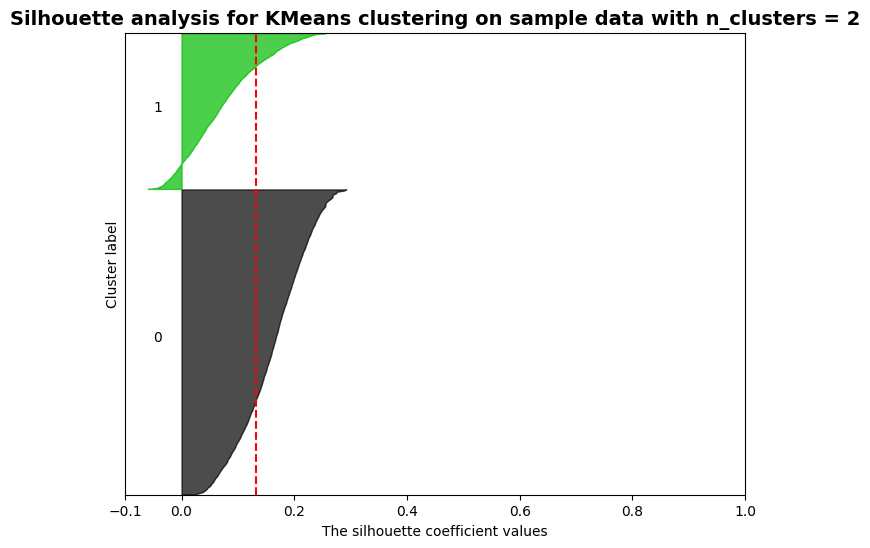

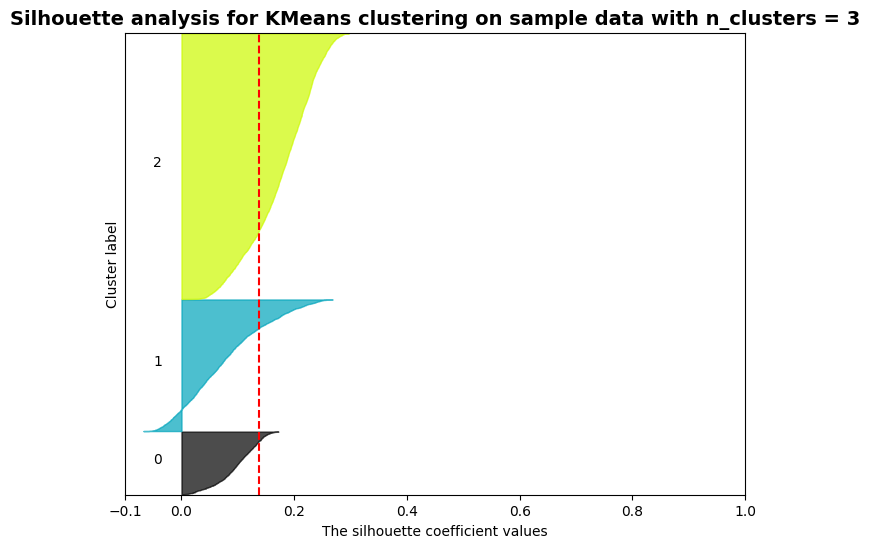

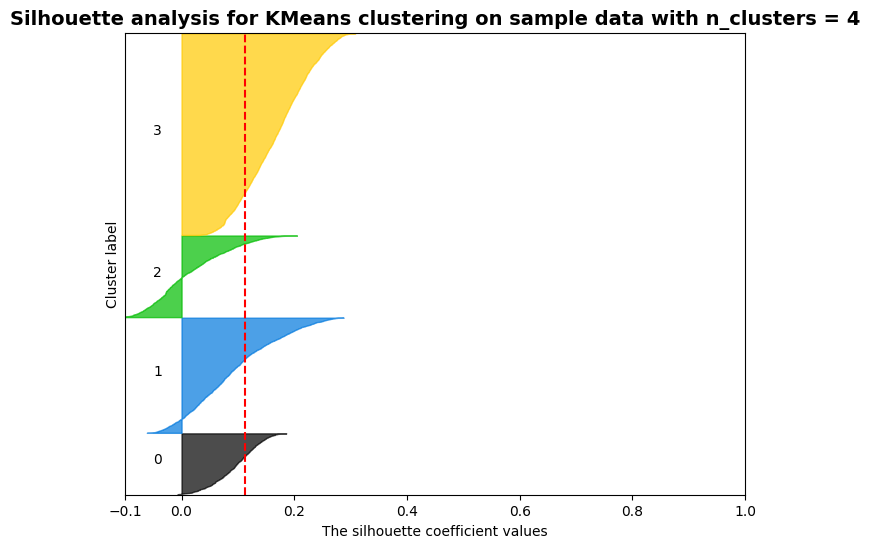

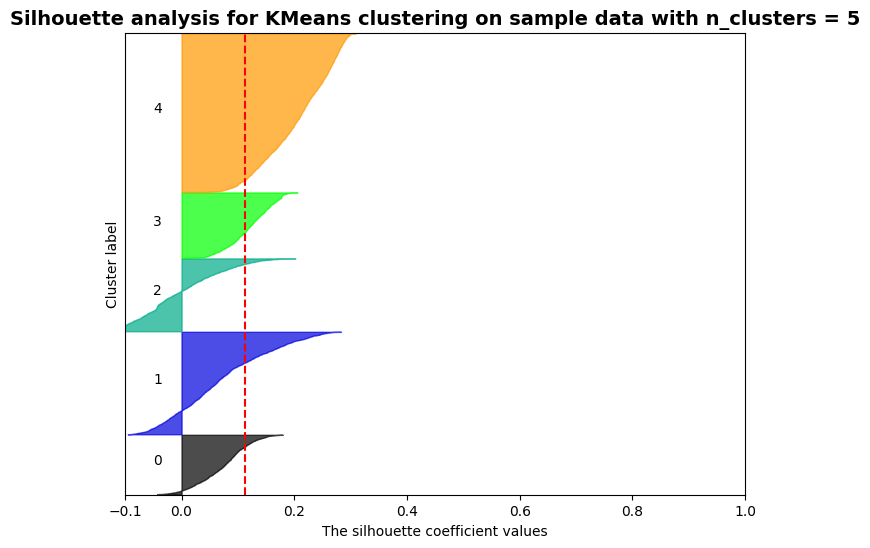

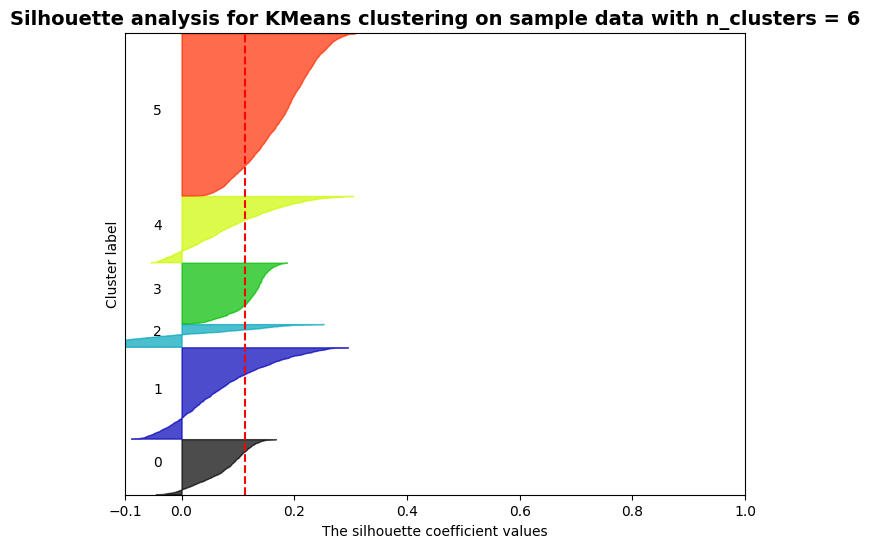

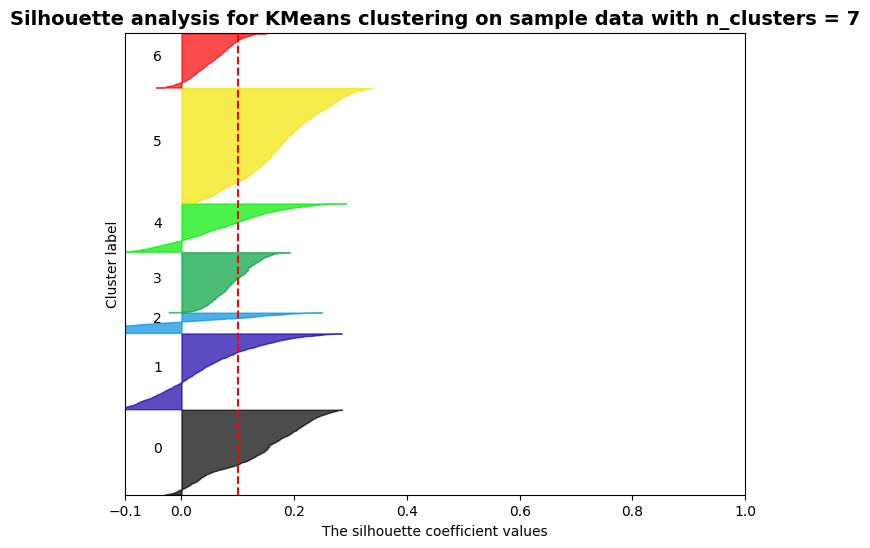

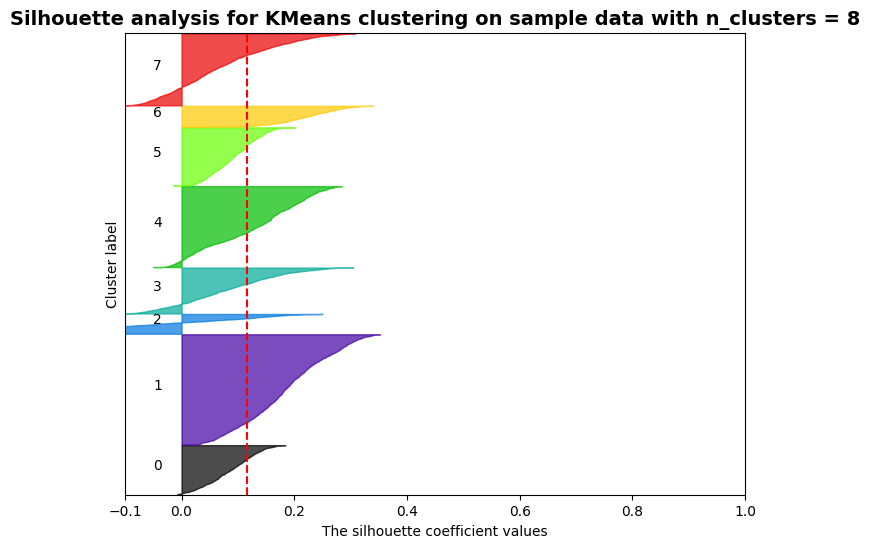

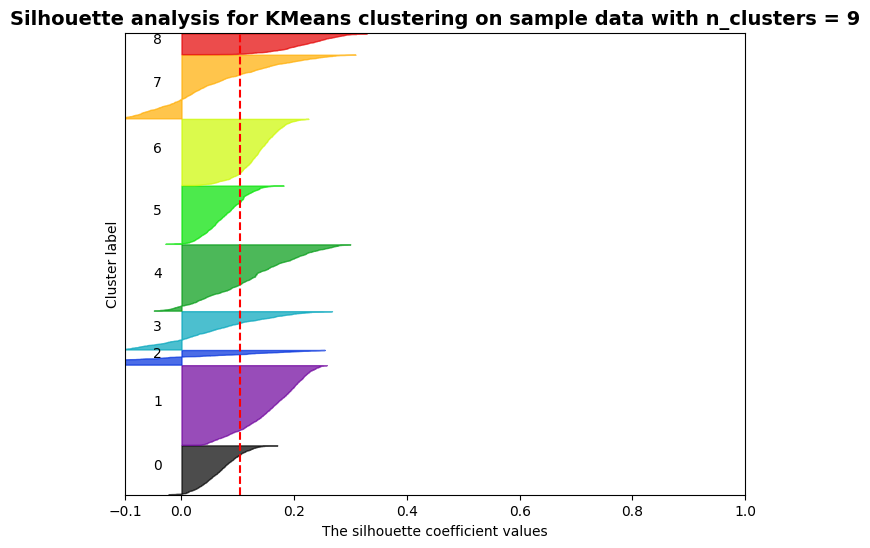

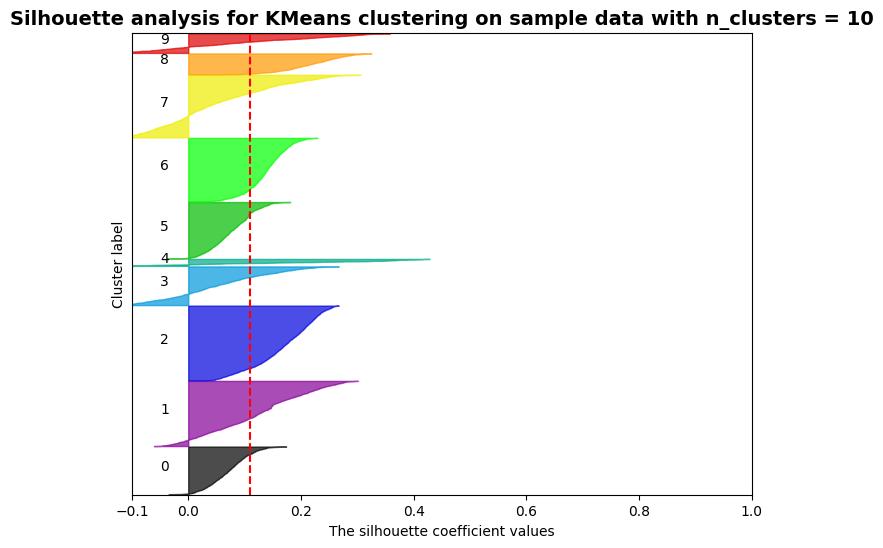

In [29]:
range_n_clusters =  [2, 3, 4, 5, 6, 7, 8, 9, 10]  ### TO COMPLETE

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples


for n_clusters in range_n_clusters:
    # Create a plot
    fig, ax  = plt.subplots(1,1, figsize=(8,6))

    # This plot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(scaled_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters.
    cluster =  KMeans(n_clusters=n_clusters, random_state=10)  ### TO COMPLETE
    cluster_labels = cluster.fit_predict(scaled_df)  ### TO COMPLETE

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg =        silhouette_score(scaled_df , cluster_labels)  ### TO COMPLETE
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values =  silhouette_samples(scaled_df , cluster_labels)  ### TO COMPLETE

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.title(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

What is, in your opinion, the best number of centers to choose?

**Answer :**  The best number of centers to choose is 3 as we obtain the highest silouhette score with it

Apply K-means again with the optimal number of centers.

In [30]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(scaled_df)

KMeans(n_clusters=3)

How many samples are in each cluster?

In [31]:
labels = kmeans.labels_
cluster_counts = pd.Series(labels).value_counts()
cluster_counts

1    3863
2    2727
0    2405
Name: count, dtype: int64

Since, the true class of each sample is known, we can use them to evaluate the clustering results we obtained.
<br>
1- Give the contingency matrix of the clustering.

In [40]:
from sklearn.metrics import confusion_matrix

new_df["binary"]= kmeans.labels_
new_df.head()


true_labels = pd.factorize(classes)[0]
true_labels

c_matrix = confusion_matrix(true_labels, new_df["binary"])
print(c_matrix)



[[1907 3020 2386]
 [ 498  843  341]
 [   0    0    0]]


2- Discuss the obtained matrix

**Answer :**  The confusion matrix shows that, while there are only two true classes, KMeans created three clusters.
Many samples from the first true class ended up in all three clusters, and samples from the second true class mainly split between two clusters.
This means KMeans detected an extra grouping within the data, making it an inadequate for this dataset.

With clustering being an unsupervised learning method, classification evaluation metrics (accuracy, precision, etc) are not appropriate. Instead, we can use clustering evaluation metrics (rand index, adjusted rand index, homogeneity, completeness and V-measure).
<br>
Check the scikit learn documentation to understand each score: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
<br>
3- Compute all metrics defined above.

In [41]:
from sklearn import metrics
metrics.rand_score(true_labels, new_df["binary"])


0.43879011181934274

In [42]:
metrics.adjusted_rand_score(true_labels, new_df["binary"])

-0.0027858881496921157

In [43]:
metrics.homogeneity_score(true_labels, new_df["binary"])

0.012229103785808722

In [36]:
metrics.completeness_score(true_labels, new_df["binary"])

0.005468539480279161

In [39]:
metrics.v_measure_score(true_labels, new_df["binary"])
new_df

,DOJ Extended,Duration to accept offer,Notice period,Offered band,Pecent hike expected in CTC,Percent hike offered in CTC,Percent difference CTC,Joining Bonus,Candidate relocate actual,Gender,Candidate Source,Rex in Yrs,LOB,Location,Age,binary
0,1,14,30,2,-20.79,13.16,42.86,0,0,0,0,7,4,8,34,0
1,0,18,30,2,50.00,320.00,180.00,0,0,1,2,8,7,2,34,0
2,0,3,45,2,42.84,42.84,0.00,0,0,1,0,4,7,8,27,2
3,0,26,30,2,42.84,42.84,0.00,0,0,1,2,4,7,8,34,2
4,1,1,120,2,42.59,42.59,0.00,0,1,1,2,6,7,8,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8990,0,4,0,1,191.67,191.67,0.00,0,0,1,2,1,4,2,34,1
8991,1,2,0,1,150.00,150.00,0.00,0,0,0,1,3,1,2,34,1
8992,0,0,0,2,35.42,35.42,0.00,0,0,1,1,5,7,8,34,2
8993,0,0,30,1,76.92,53.85,-13.04,0,0,1,1,4,7,8,34,2


4- Discuss the obtained scores.

The clustering results are weak:  
- **Rand Index** (0.41): Shows limited accuracy.  
- **Adjusted Rand Index** (0.0047): Almost no alignment with true classes.  
- **Homogeneity** (0.014) and **Completeness** (0.0051): Clusters mix up classes and fail to group class members together.  
- **V-measure** (0.0076): Confirms poor overall clustering quality.  

The clustering doesn’t match the true data structure well.


### Clustering algorithm 2: Hierarchical clustering

Apply the hierarchical clustering algorithm with 2 centers. Look at the default parameters and make sure the algorithm is based on the single linkage method.

In [46]:
from sklearn.cluster import AgglomerativeClustering
hclust = AgglomerativeClustering(n_clusters= 2 , linkage='single')
hclust.get_params()

{'compute_distances': False,
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'single',
 'memory': None,
 'metric': 'euclidean',
 'n_clusters': 2}

In [47]:
hclust.fit(scaled_df)

AgglomerativeClustering(linkage='single')

How many samples are in each cluster?

In [48]:
labels = hclust.labels_
cluster_counts = pd.Series(labels).value_counts()
cluster_counts

0    8994
1       1
Name: count, dtype: int64

Apply the hierarchical clustering algorithm again. This time,  change the linkage method to complete linkage.

In [49]:
hclust = AgglomerativeClustering(n_clusters= 2 , linkage='complete')

In [50]:
hclust.fit(scaled_df)

AgglomerativeClustering(linkage='complete')

How many samples are in each cluster?

In [52]:
labels = hclust.labels_
cluster_counts = pd.Series(labels).value_counts()
cluster_counts

0    8983
1      12
Name: count, dtype: int64

Apply the hierarchical clustering algorithm once again. This time, change the linkage method to ward linkage.

In [53]:
hclust = AgglomerativeClustering(n_clusters= 2 , linkage='ward')
hclust.fit(scaled_df)

AgglomerativeClustering()

How many samples are in each cluster?

In [54]:
labels = hclust.labels_
cluster_counts = pd.Series(labels).value_counts()
cluster_counts

1    5959
0    3036
Name: count, dtype: int64

Compare the three results. Is the type of linkage method used important? Which one gave you the best result? For the rest of this section, use the best linkage method.

**Answer :**  

We obtain different results depending on which type of linkage we used.  
- **Single Linkage**: created one large cluster and isolated one outlier point.  
- **Complete Linkage**: grouped most points together, with a smaller cluster of 12 points.  
- **Ward Linkage**: divided the data more evenly into two clusters.  

**Ward's method** gives the most balanced results of all three.


In order to optimize our clusters, we want to apply the silhouette method to obtain the optimal number of centers.
Apply silhouette on a range from 2 to 10 centers, display the average silhouette score for each and display the silhouette plot for each center.
<br> For some help, look at the silhouette documentation in scikit learn: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

<br>

Please note that the code below is NOT complete. Fill in the missing parts (they are indicated by ### TO COMPLETE)

For n_clusters = 2 The average silhouette_score is : 0.1040443284660387
For n_clusters = 3 The average silhouette_score is : 0.10357671210193742
For n_clusters = 4 The average silhouette_score is : 0.1071763726490317
For n_clusters = 5 The average silhouette_score is : 0.11489388619056004
For n_clusters = 6 The average silhouette_score is : 0.11709642581041917
For n_clusters = 7 The average silhouette_score is : 0.12367408434054206
For n_clusters = 8 The average silhouette_score is : 0.09809353434400632
For n_clusters = 9 The average silhouette_score is : 0.07742691837401199
For n_clusters = 10 The average silhouette_score is : 0.08022361543712099


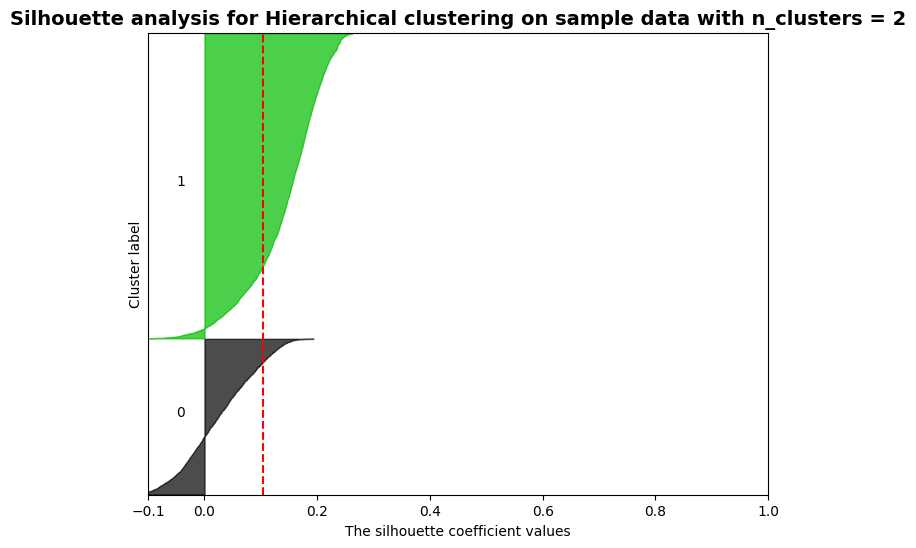

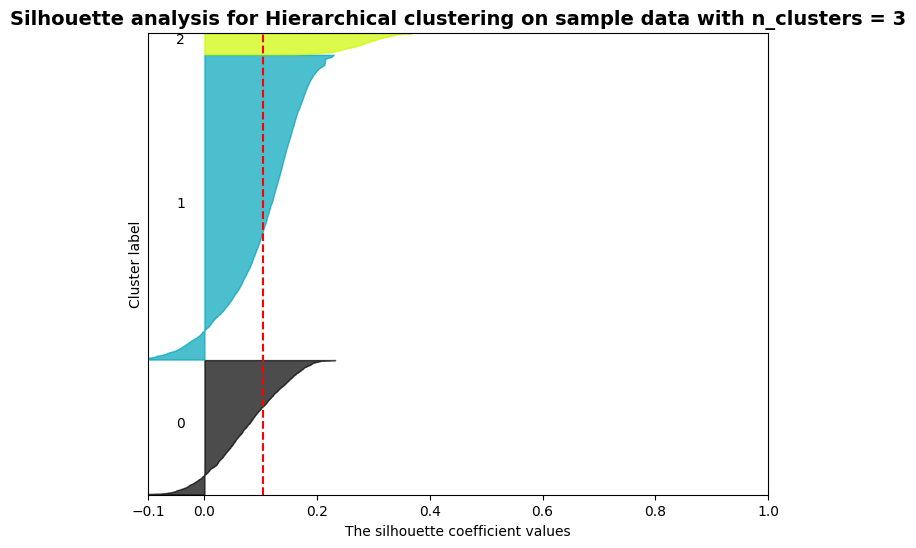

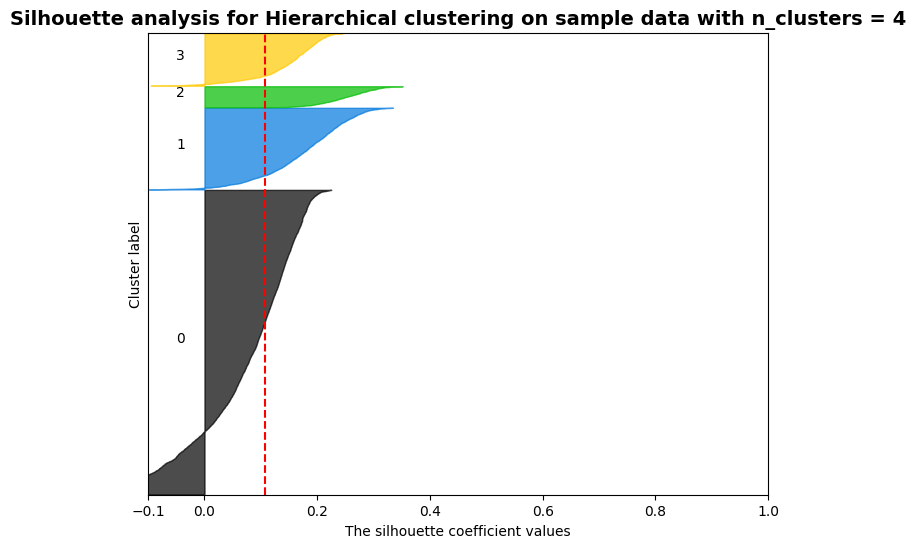

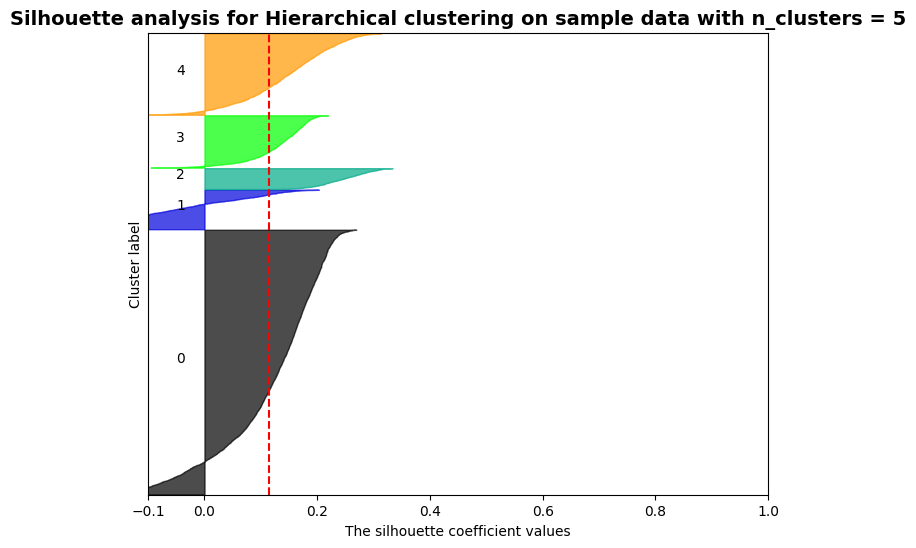

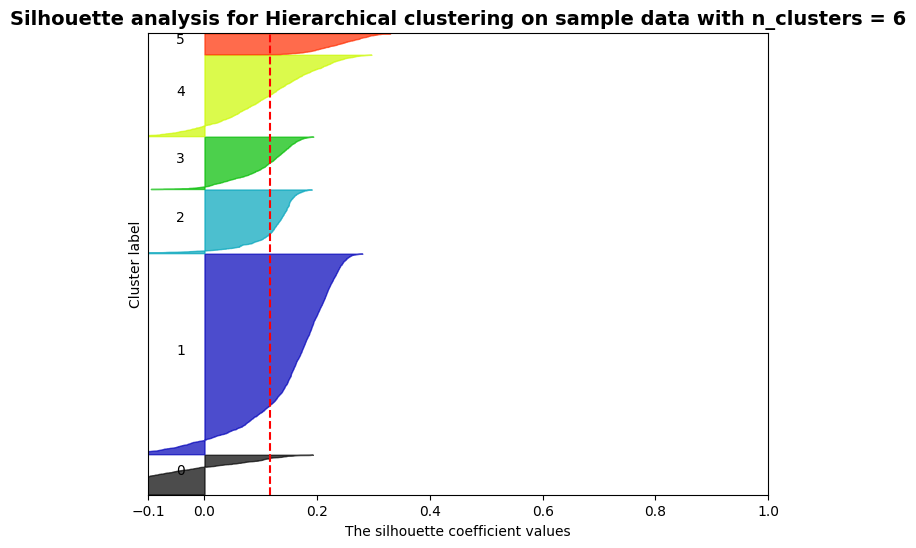

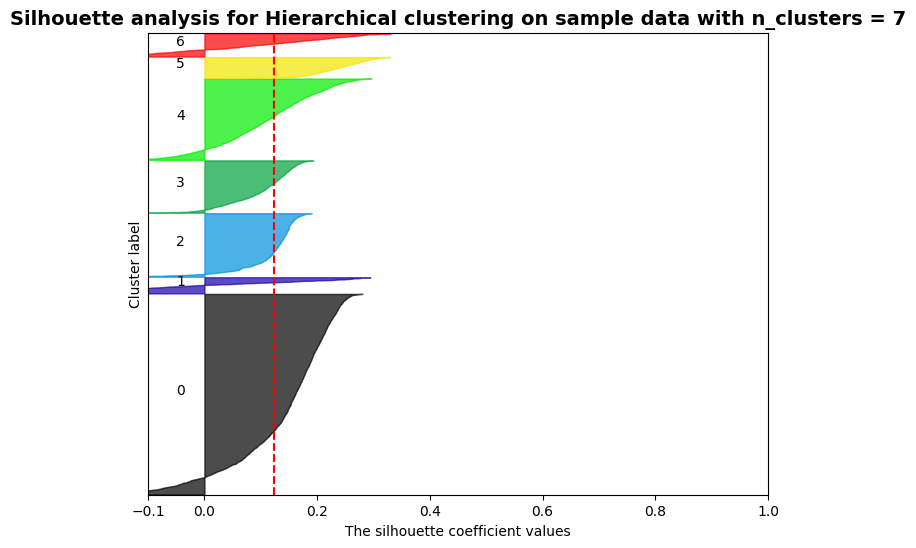

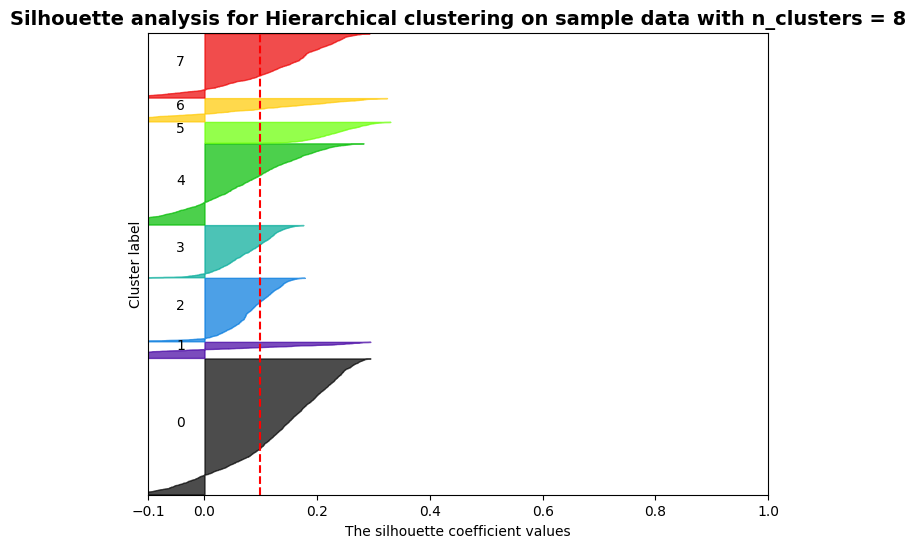

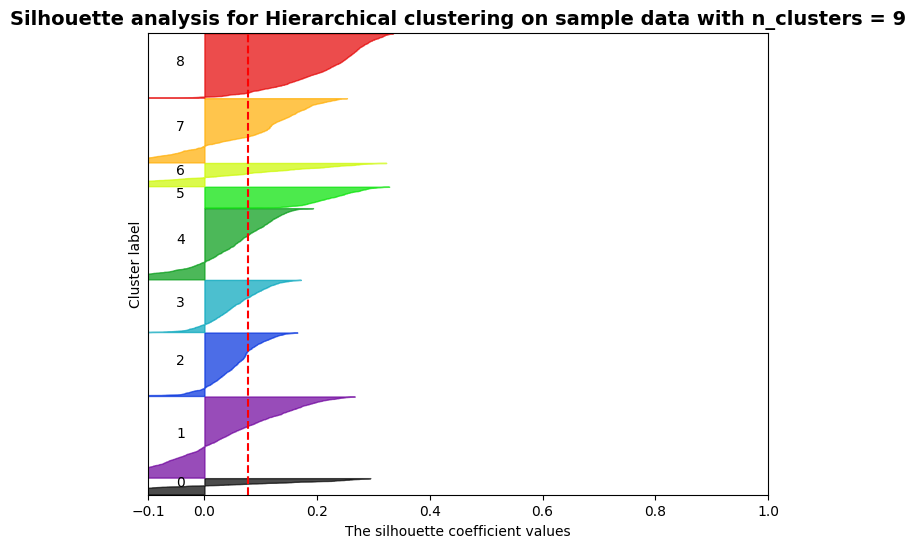

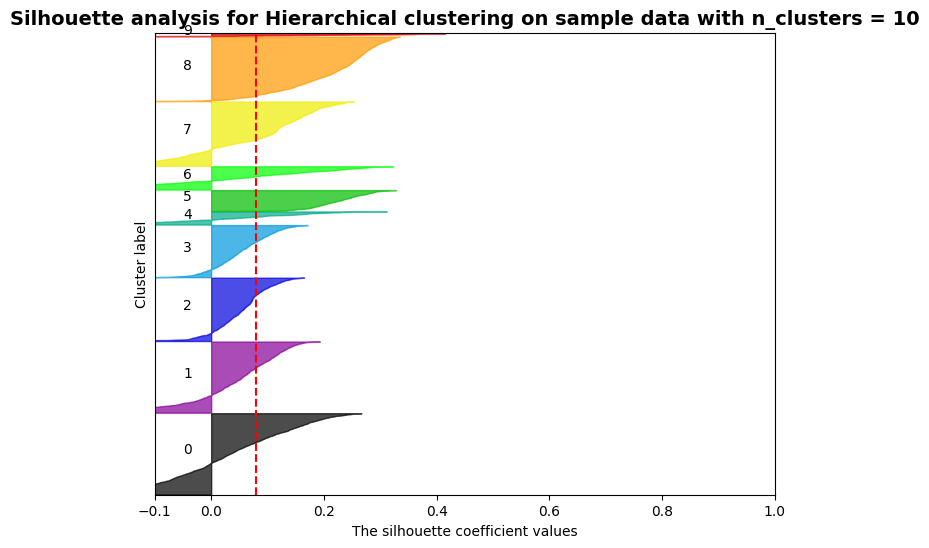

In [66]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]  ### TO COMPLETE

import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples


for n_clusters in range_n_clusters:
    # Create a plot
    fig, ax  = plt.subplots(1,1, figsize=(8,6))

    # This plot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(scaled_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters and the linkage method you
    # determined worked best.
    clusterer =  AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')  ### TO COMPLETE
    cluster_labels = clusterer.fit_predict(scaled_df)   ### TO COMPLETE

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scaled_df, cluster_labels)### TO COMPLETE
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_df, cluster_labels)### TO COMPLETE

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.title(("Silhouette analysis for Hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

What is, in your opinion, the best number of centers to choose?

**Answer :**  

The best number of centers to choose is **7** it provides the highest silouhette average

Apply hierarchical clustering again with the optimal number of centers.

In [55]:
hclust = AgglomerativeClustering(linkage='ward', n_clusters= 7)
hclust.fit(scaled_df)

AgglomerativeClustering(n_clusters=7)

How many samples are in each cluster?

In [56]:
labels = hclust.labels_
cluster_counts = pd.Series(labels).value_counts()
cluster_counts

0    3935
4    1597
2    1249
3    1027
6     458
5     412
1     317
Name: count, dtype: int64

Since, the true class of each sample is known, we can use them to evaluate the clustering results we obtained.
<br>
1- Give the contingency matrix of the clustering.

In [57]:
from sklearn.metrics import confusion_matrix

new_df["binary"]= hclust.labels_
new_df.head()


true_labels = pd.factorize(labels)[0]
true_labels

c_matrix = confusion_matrix(true_labels, new_df["binary"])
print(c_matrix)


[[   0    0 1249    0    0    0    0]
 [   0  317    0    0    0    0    0]
 [3935    0    0    0    0    0    0]
 [   0    0    0 1027    0    0    0]
 [   0    0    0    0 1597    0    0]
 [   0    0    0    0    0    0  458]
 [   0    0    0    0    0  412    0]]


2- Discuss the obtained matrix.

The confusion matrix shows that, while there are only two true classes, **Hierarchical Clustering** created seven clusters.  
There is clear separation between the clusters with no overlap, which means that the two true clusters have been broken down into seven.  
We also notice that the third class is by far the largest, containing 3935 points, which could mirror the true first class that contains over 3000 elements.  
This means **Hierarchical Clustering** detected an extra grouping within the data, making it inadequate for this dataset.


With clustering being an unsupervised learning method, classification evaluation metrics (accuracy, precision, etc) are not appropriate. Instead, we can use clustering evaluation metrics (rand index, adjusted rand index, homogeneity, completeness and V-measure).
<br>
Check the scikit learn documentation to understand each score: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
<br>
3- Compute all metrics defined above.

In [58]:
from sklearn import metrics
metrics.rand_score(true_labels, new_df["binary"])

1.0

In [59]:

metrics.adjusted_rand_score(true_labels, new_df["binary"])

1.0

In [61]:
metrics.homogeneity_score(true_labels, new_df["binary"])

1.0

In [62]:
metrics.completeness_score(true_labels, new_df["binary"])


1.0

In [63]:
metrics.v_measure_score(true_labels, new_df["binary"], beta=1.8)


1.0

4- Discuss the obtained scores.

**Answer :** 

Since there are only two true classes, getting perfect scores with **Hierarchical Clustering**, even after specifying seven clusters, probably means the algorithm has split each of the classes into several clusters without overlap.  
This alignment across multiple clusters made the metrics reach 1.0, since the clusters still match the class boundaries perfectly despite being over-divided.  
**Hierarchical Clustering** has overfitted to the true class structure, breaking it into several parts while still maintaining a match with the real classes.


OPTIONAL: plot the dendrogram

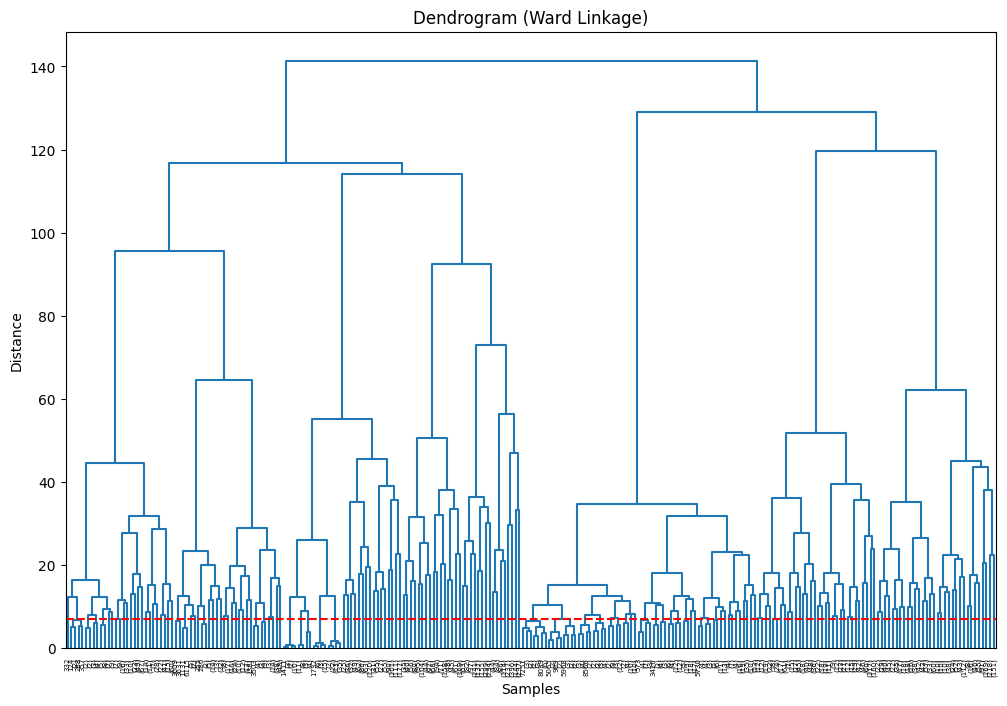

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

if isinstance(scaled_df, np.ndarray):
    scaled_df = pd.DataFrame(scaled_df)  

# Compute the linkage matrix using the Ward method
linkage_matrix = linkage(scaled_df, method='ward')

# Create the dendrogram
plt.figure(figsize=(12, 8))
plt.title("Dendrogram (Ward Linkage)")
dendrogram(linkage_matrix, 
           truncate_mode='level',  # To show a specific number of levels
           p=7,  # Show the last 7 levels
           color_threshold=0)  # Color threshold (0 means no threshold)

plt.xlabel("Samples")
plt.ylabel("Distance")
plt.axhline(y=7, color='r', linestyle='--') 
plt.show()


## Spectral clustering and comparison

### Clustering algorithm 3: Spectral clustering

Apply the spectral clustering algorithm with 2 centers.

In [ ]:

from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances
import numpy as np

# Assuming 'scaled_df' is your original data
# Calculate the distance matrix
distance_matrix = pairwise_distances(scaled_df, metric='euclidean')

# Convert to affinity matrix using Gaussian kernel
sigma = np.mean(distance_matrix)
affinity_matrix = np.exp(-distance_matrix**2 / (2 * sigma**2))

# Initialize SpectralClustering with 'precomputed' affinity
spectralC = SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity='precomputed')





SpectralClustering(affinity='precomputed', eigen_solver='arpack', n_clusters=2)

In [72]:
spectralC.get_params()

{'affinity': 'precomputed',
 'assign_labels': 'kmeans',
 'coef0': 1,
 'degree': 3,
 'eigen_solver': 'arpack',
 'eigen_tol': 'auto',
 'gamma': 1.0,
 'kernel_params': None,
 'n_clusters': 2,
 'n_components': None,
 'n_init': 10,
 'n_jobs': None,
 'n_neighbors': 10,
 'random_state': None,
 'verbose': False}

In [74]:
spectralC.fit(affinity_matrix)

SpectralClustering(affinity='precomputed', eigen_solver='arpack', n_clusters=2)

How many samples are in each cluster?

In [75]:
labels = spectralC.labels_
cluster_counts = pd.Series(labels).value_counts()
cluster_counts

0    6145
1    2850
Name: count, dtype: int64

Apply the spectral clustering algorithm again. This time, change the method to construct the affinity matrix to "nearest_neighbors".

In [76]:
spectralC = SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity='nearest_neighbors')
spectralC.get_params()

{'affinity': 'nearest_neighbors',
 'assign_labels': 'kmeans',
 'coef0': 1,
 'degree': 3,
 'eigen_solver': 'arpack',
 'eigen_tol': 'auto',
 'gamma': 1.0,
 'kernel_params': None,
 'n_clusters': 2,
 'n_components': None,
 'n_init': 10,
 'n_jobs': None,
 'n_neighbors': 10,
 'random_state': None,
 'verbose': False}

In [77]:
spectralC.fit(scaled_df)

c:\Python\Python312\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SpectralClustering(affinity='nearest_neighbors', eigen_solver='arpack',
                   n_clusters=2)

How many samples are in each cluster?

In [79]:
labels = spectralC.labels_
cluster_counts = pd.Series(labels).value_counts()
cluster_counts

0    8964
1      31
Name: count, dtype: int64

Compare the two results. Is the method used to construct the affinity matrix important? Which one gave you the best result? For the rest of this section, use the best method.

When using the **Nearest Neighbors** method, the clustering results were heavily imbalanced, with one cluster containing 8984 points and the other only 11. As suggested in the warning, the nearest neighbor method may be ill-fitted here because the graph is not fully connected.  
In contrast, the **Gaussian Kernel** method produced a more balanced distribution: 6143 points in one cluster and 2852 in the other.  
The method used to construct the affinity matrix is important, and the **Gaussian Kernel** method gave better results.


In order to optimize our clusters, we want to apply the silhouette method to obtain the optimal number of centers.
Apply silhouette on a range from 2 to 10 centers, display the average silhouette score for each and display the silhouette plot for each center.
<br> For some help, look at the silhouette documentation in scikit learn: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

<br>

Please note that the code below is NOT complete. Fill in the missing parts (they are indicated by ### TO COMPLETE)

For n_clusters = 2 The average silhouette_score is : 0.16914073751804262
For n_clusters = 3 The average silhouette_score is : 0.09428642116819887
For n_clusters = 4 The average silhouette_score is : 0.6803564457385886
For n_clusters = 5 The average silhouette_score is : 0.14509536310982066
For n_clusters = 6 The average silhouette_score is : 0.15129523157824615
For n_clusters = 7 The average silhouette_score is : 0.20468265342424277
For n_clusters = 8 The average silhouette_score is : 0.12881697260621414
For n_clusters = 9 The average silhouette_score is : 0.10292145125953964
For n_clusters = 10 The average silhouette_score is : 0.1437671765190501


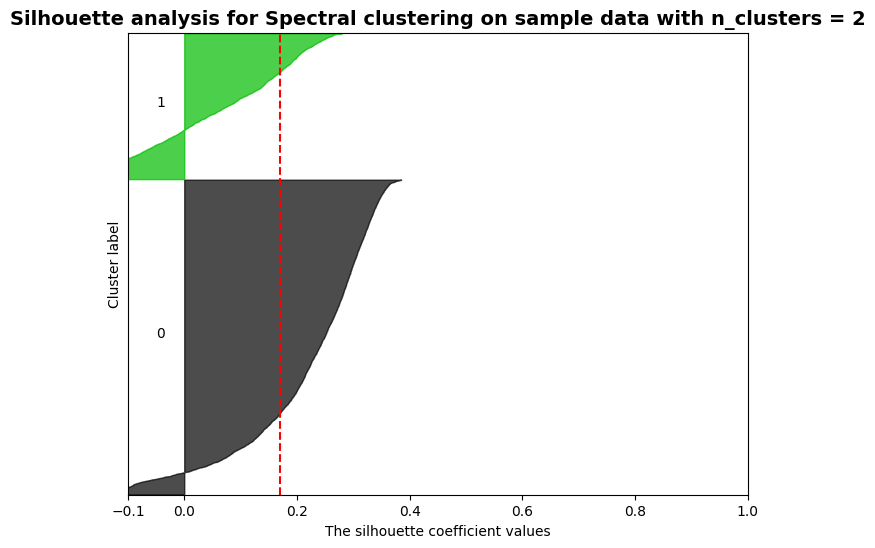

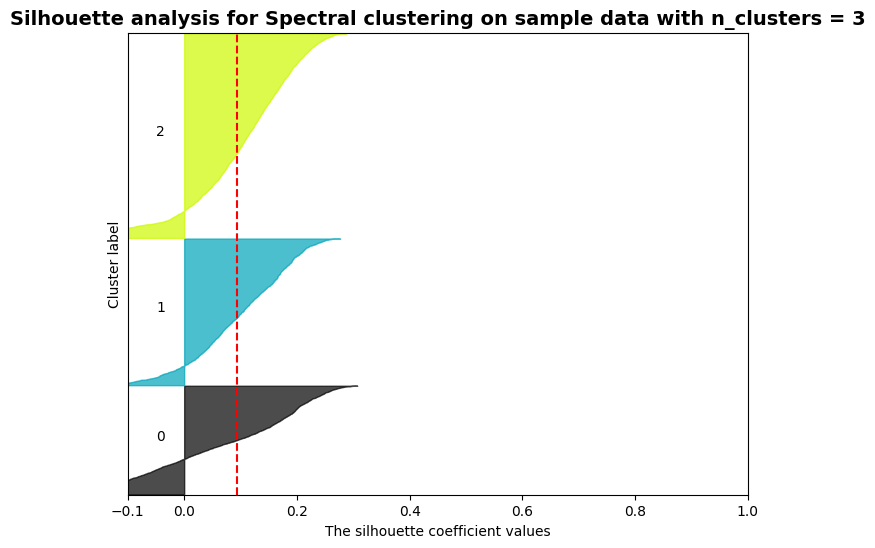

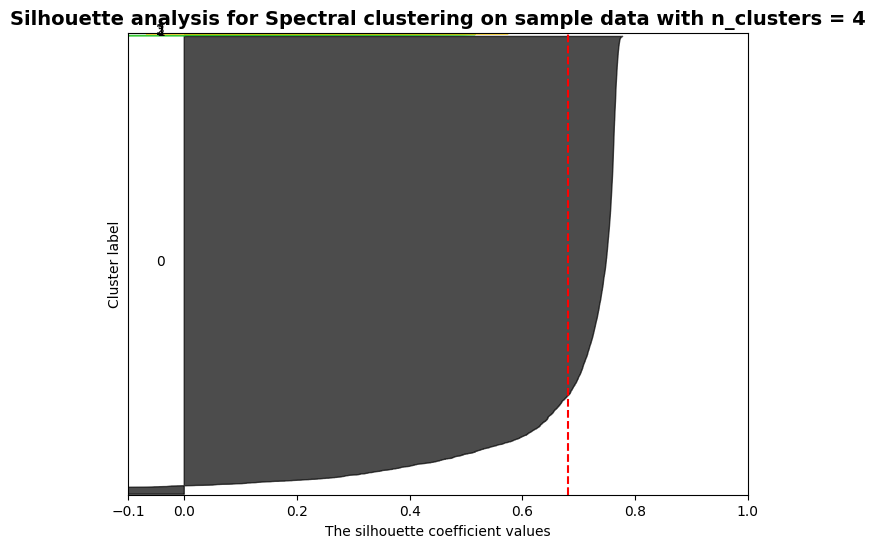

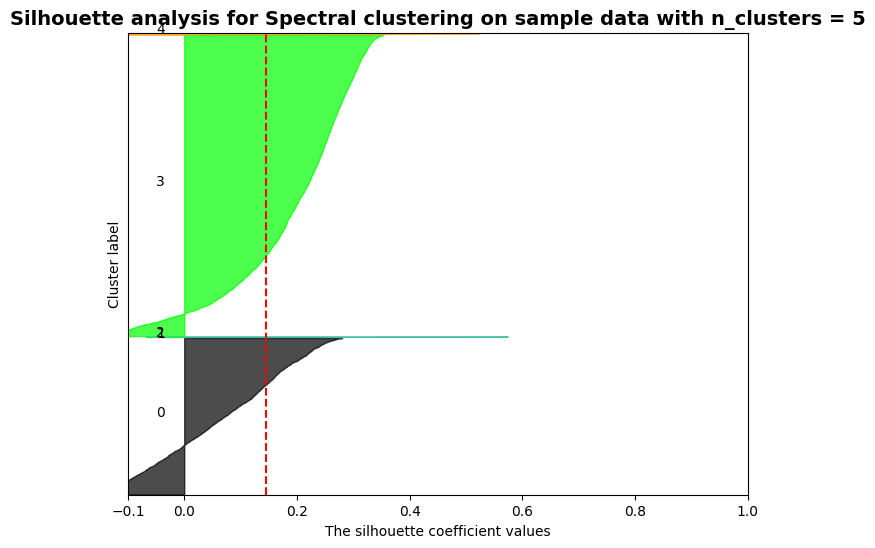

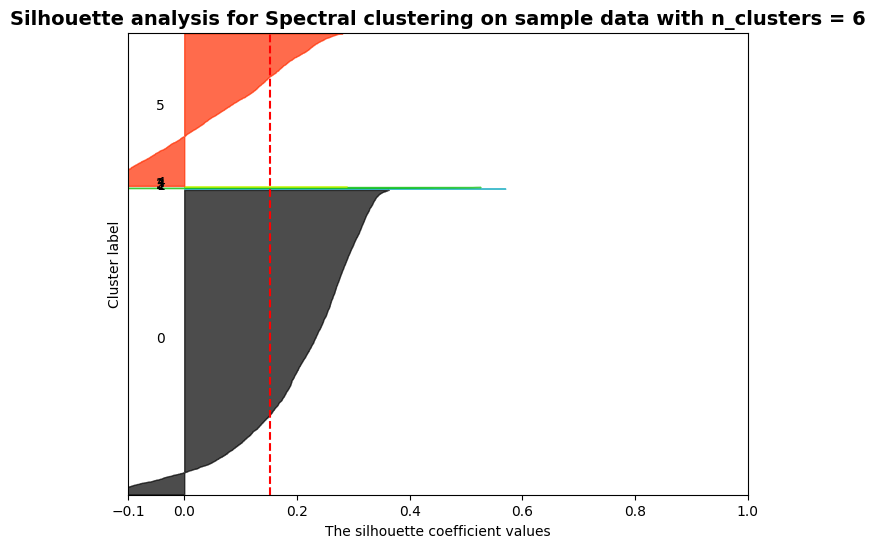

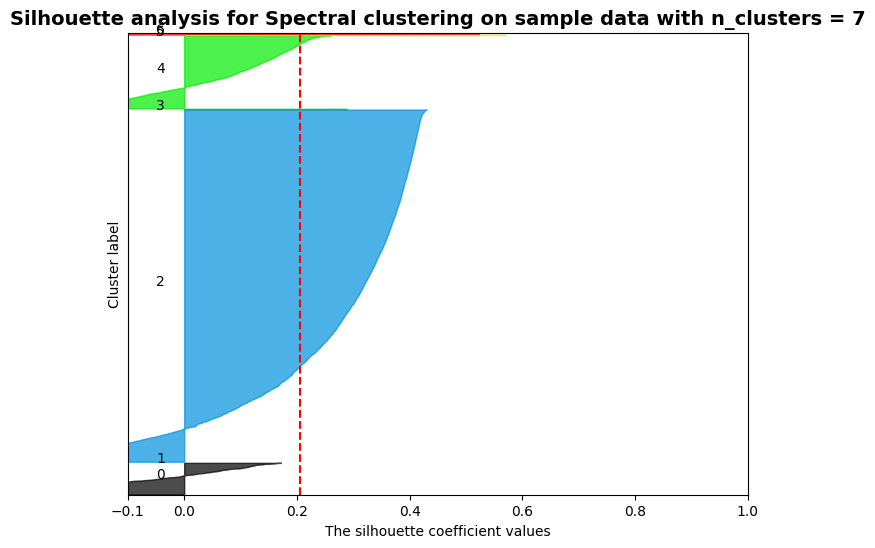

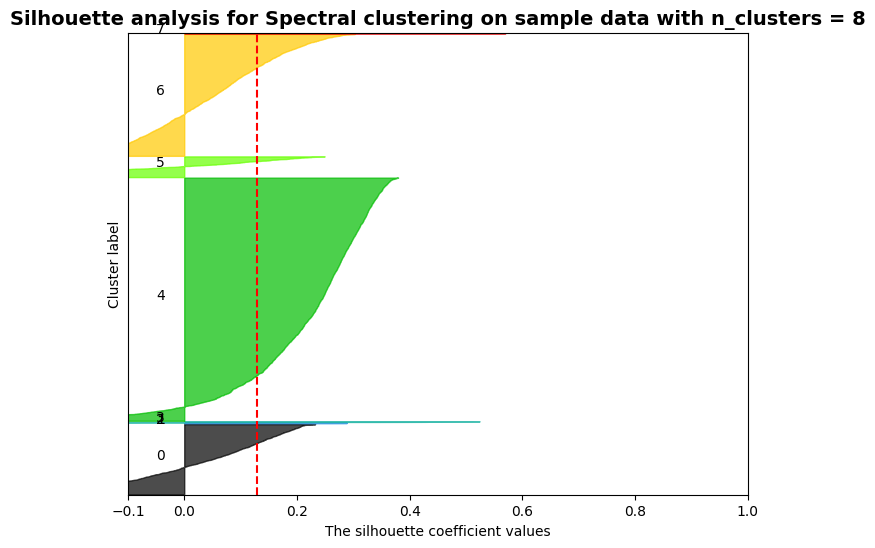

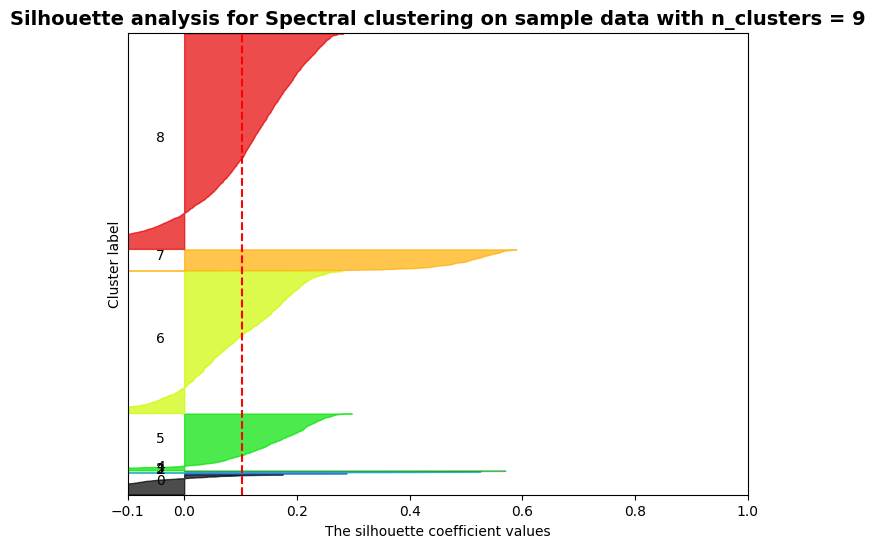

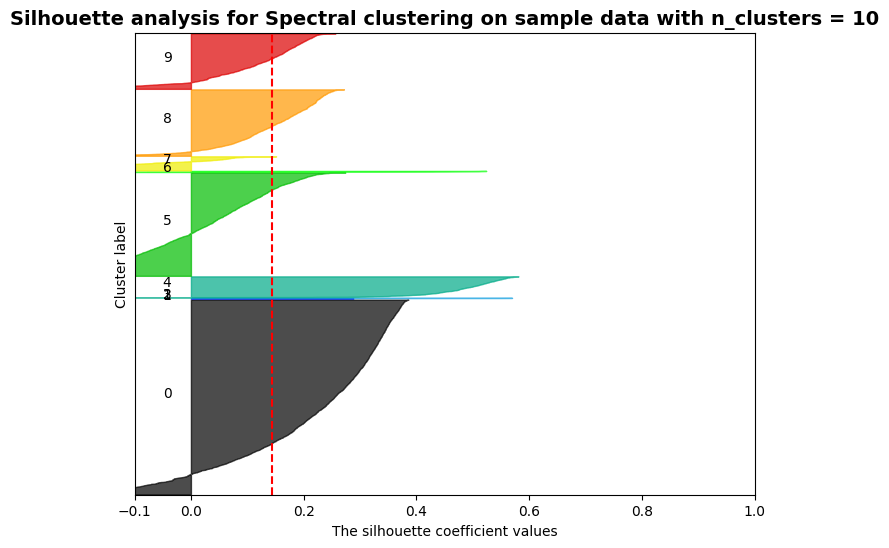

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances
from sklearn.cluster import SpectralClustering

# Range of clusters to test
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Assuming 'scaled_df' is your original data
# Calculate the distance matrix
distance_matrix = pairwise_distances(scaled_df, metric='euclidean')

# Convert to affinity matrix using Gaussian kernel
sigma = np.mean(distance_matrix)  # Example for setting sigma
affinity_matrix = np.exp(-distance_matrix**2 / (2 * sigma**2))

# Loop through the specified range of clusters
for n_clusters in range_n_clusters:
    # Create a plot
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(scaled_df) + (n_clusters + 1) * 10])

    # Initialize SpectralClustering with 'precomputed' affinity
    clusterer = SpectralClustering(n_clusters=n_clusters, eigen_solver='arpack', affinity='precomputed')
    cluster_labels = clusterer.fit_predict(affinity_matrix)

    # Calculate the average silhouette score
    silhouette_avg = silhouette_score(affinity_matrix, cluster_labels)  # Use affinity_matrix instead of scaled_df
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(affinity_matrix, cluster_labels)  # Use affinity_matrix

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Update y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # Vertical line for average silhouette score
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the y-axis labels/ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.title(("Silhouette analysis for Spectral clustering on sample data "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

plt.show()


What is, in your opinion, the best number of centers to choose?

**Answer :**  

The best number of centers to choose is **4** as it provides the highest silouhette average

Apply spectral clustering again with the optimal number of centers.

In [81]:
distance_matrix = pairwise_distances(scaled_df, metric='euclidean')

# Convert to affinity matrix using Gaussian kernel
sigma = np.mean(distance_matrix)
affinity_matrix = np.exp(-distance_matrix**2 / (2 * sigma**2))

# Initialize SpectralClustering with 'precomputed' affinity
spectralC = SpectralClustering(n_clusters=4, eigen_solver='arpack', affinity='precomputed')


spectralC.fit(affinity_matrix)

SpectralClustering(affinity='precomputed', eigen_solver='arpack', n_clusters=4)

How many samples are in each cluster?

In [82]:
labels = spectralC.labels_
cluster_counts = pd.Series(labels).value_counts()
cluster_counts

0    8963
3      26
2       5
1       1
Name: count, dtype: int64

Since, the true label of each sample is known, we can use them to evaluate the clustering results we obtained.
<br>
<br>
1- Give the contingency matrix of the clustering.

In [83]:
new_df["binary"]= spectralC.labels_
new_df.head()


true_labels = pd.factorize(labels)[0]
true_labels

c_matrix = confusion_matrix(true_labels, new_df["binary"])
print(c_matrix)

[[8963    0    0    0]
 [   0    0    0   26]
 [   0    0    5    0]
 [   0    1    0    0]]


2- Discuss the obtained matrix.

**Answer :**  

The clustering seems to fit the data cleanly into four classes, but the majority of the data has been captured in one main cluster, leaving only small groups isolated.  
There is a clear imbalance in regards to the two clusters.


With clustering being an unsupervised learning method, classification evaluation metrics (accuracy, precision, etc) are not appropriate. Instead, we can use clustering evaluation metrics (rand index, adjusted rand index, homogeneity, completeness and V-measure).
<br>
Check the scikit learn documentation to understand each score: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
<br>
3- Compute all metrics defined above.

In [85]:
metrics.rand_score(true_labels, new_df["binary"])

1.0

In [86]:
metrics.adjusted_rand_score(true_labels, new_df["binary"])

1.0

In [87]:
metrics.homogeneity_score(true_labels, new_df["binary"])

1.0

In [88]:
metrics.completeness_score(true_labels, new_df["binary"])

1.0000000000000002

In [89]:
metrics.v_measure_score(true_labels, new_df["binary"], beta=1.8)

1.0

4- Discuss the obtained scores.

**Answer :**

The perfect scores from **Spectral Clustering** indicate good alignment with the true classes.  
However, the clustering is highly imbalanced, with one cluster containing almost all of the labels, indicating imbalance and showing that the algorithm did not capture the broader data structure.  

So, while the metrics look great, the clustering doesn't reflect the true class balance in the data at all.


### Conclusion

In your opinion, which method gave the better results for this dataset?

**Answer :**

As we know, the true class distribution is 7313 and 1682 between two clusters.

The **Spectral Clustering with Gaussian Kernel** appears to give the best results for this dataset, with clusters of 6143 and 2852 samples. It does not perfectly align with the true classes, but it is the closest to reflecting a more balanced separation compared to the other methods.

In comparison, the **Nearest Neighbors** and **Single Linkage Hierarchical Clustering** methods produced highly imbalanced clusters (e.g., 8984 and 11 or 8964 and 31), which is very far from reflecting the true structure.

We also notice that the **KMeans** and **Ward Linkage Clustering** produce identical clusters, containing 5959 and 3034 samples each. This similarity suggests that both methods are grouping data based on similar metrics (global distance, ...), creating more balanced clusters. However, these clusters don’t align with the true class distribution either, likely because the natural data structure doesn’t fit perfectly with the spherical clusters that the methods tend to favor.

Therefore, **Spectral Clustering with Gaussian Kernel** seems to be the most effective choice for this dataset.
<br>
<br>

Usually, when we apply different clustering methods, it's because we do not know the classes. In such situation, we compare the different clustering models we obtained with each method to each other to see if they are corroborating.
<br>
Pick two of the three clustering methods used above, and use the same metrics as before to compare them (do not rerun the models, just compare the predicted clusters you obtained with each method).  

**Answer :** 

We will be comparing the **Hierarchical** and **KMeans Clustering** methods.

**Hierarchical Clustering** (with all metrics at 1.0) suggests that it produced perfectly separated clusters according to these metrics. However, this does not align with the true results at all; it only shows that the method captured distinct clusters, but not necessarily the true underlying classes, as we know the actual distribution is not exactly reflected by these clusters.

**KMeans** (Rand Index: 0.409, Adjusted Rand Index: 0.0047, Homogeneity: 0.0143, Completeness: 0.0051, V-measure: 0.0076): with much lower metrics, indicates that it had more difficulty forming clusters that closely match the true class distribution. Its results show that it partially captured the structure but did not create as distinct a separation as **Hierarchical Clustering**.


Discuss the obtained scores.

**Answer :**

The high scores for **Hierarchical Clustering** may suggest that it overfits to very specific cluster boundaries in this dataset. In contrast, **KMeans** provides a more realistic clustering. Based on these results, **Hierarchical Clustering** would seem like the better clustering model, but the overly perfect metrics could indicate a less flexible separation that, as we know, does not truly represent the data’s actual class structure nor the sample numbers in each class.


At the beginning of the practical, you noticed the number of classes in the data. After completing all the work, applying silhouette and finding the optimal number of clusters, were you expecting the results you obtained? Can you find an explanation for the result?

**Answer :**

Given that we started with the knowledge that there are only two true classes, "Joined" and "Not Joined," the results were very unexpected. The optimal number of clusters varied for each method: **KMeans** suggested 3, **Hierarchical Clustering** indicated 7, and **Spectral Clustering** pointed to 4.

This discrepancy likely relates to the internal structure of the dataset (overlapping regions or subclusters, ...). This can lead clustering algorithms to identify more groups than actually exist. Each method’s clustering tendency also plays a role: **Hierarchical Clustering** can be sensitive to local densities, while **Spectral Clustering** tends to capture more nuanced relationships that could cause it to split each class into finer clusters.
